In [2]:
import numpy as np
import matplotlib.pylab as plt

# A small step into FEM
## Intro to the problem
First of all we want to solve an partial differential equation. In this case we just want to solve the simple equation
$$
y'(x) = 0,
$$
The analytical solution to this problem is trivially 
$$
y = a\cdot x + b.
$$
If we give also boundary conditions like $y(0)=3$ and $y(4)=5$, we can get the unique solution
$$
y(x) = \frac{1}{2}x + 3.
$$
## Idea of FEM
So we now want to compute this solution (or an approximation of it) numerically.   
In the start we assume that the exact solution $y$ is element of a function space, that also is a vector space $V$. We also assume, that this vector space $V$ is normed and we define an inner product as
$$
 <f, g>~ = \int_\Omega f\cdot g~dx = \int_0^4 f\cdot g~dx.
$$
We also know, that the derivative operator $\frac{d}{dx} \equiv D$ is a linear map from $V$ to another vector space $V'$. In this simple demo we wrongly assume that $V$ and $V'$ are the same spaces. We can write our original problem now as
$$
Dy = 0.
$$
We can use a theorem (called Lax-Milgram and without showing, that it can be applied here), to state the following as equivalent:
$$
<Dy, v> ~=~ <0,v> ~= 0 \hspace{1cm} \forall v \in V.
$$
This is called the weak formulation. If we now find a basis of $V$, we can plug these basis vectors $b_i$ one after another into $y$ and check if $<Db_i, v>=0$ holds for all $v$.
After this have our complete solution space and simply have to put in the boundary conditions to find our explicit solution. We even don't have to check for every $v$ but can also put in there just the different $b_i$. The problem here, that the solution space maybe infinite dimensional and therefore the basis arbitrarily big. So the next big idea is to only take a subspace of the original vectorspace $V$ and create a finite dimensional basis. We now call this vectorspace $\tilde{V}$. Another obserservation helps us to choose a good subspace and corresponding basis for the problem. Most function look localy very much like linear, quadric or other low order polynomials. So we can split our domain up and and define functions, that are practially low order polynomials, but only 'show' their correct values in a small subdomain. These functions are called _shapefunctions_. One could be difined as
$$
v = \begin{cases}
    -x + 2  &\text{if}~~1\leq x \leq 2\\
    3 &\text{else}
    \end{cases}
$$
This has the benifit, that most of the basis functions don't 'overlap' and we can directly know, that the inner product is 0. Only shape functions, that are active on the same subdomain, need to be calculated explicitly. To further minimize calculations, we split the domain up in subdomains (called _elements_) and add  shapefunctions, that look the same ine each subdomain, but only shifted to the center of the domain. We then define a reference element on a simple domain. In our 1-D case we choose the domain $[0,1]$. We propose the following shapefunctions on this element:
$$
v_1 = 2 \cdot (x-\frac{1}{2})(x-1) = 2x^2 - 3x + 1\\
v_2 = -4x (x-1) = -4x^2 + 4x\\
v_3 = 2 \cdot x (x-\frac{1}{2}) = 2x^2 - x\\
$$
These are an example of a set of quadratic shapefunctions. They are not chosen at random. We build them in a way that they correspond to three points: $p_1=0, p_2=\frac{1}{2}, p_3=1$. What we wanted to achieve, that each shape function is 1 on there 'own' corresponding point and zero on the other two points. This can be easily seen in the next plot. This property can also be written as $v_i(p_j) = \delta_{ij}$, where $\delta_{ij}$ is the kronecka delta.

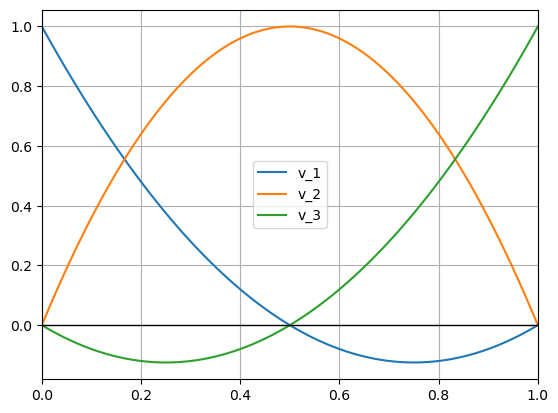

In [24]:
def v_1(x):
    return 2*x**2 - 3*x + 1

def v_2(x):
    return -4*x**2 + 4*x

def v_3(x):
    return 2*x**2 - x

x = plt.linspace(0, 1, 100)
plt.plot(x, v_1(x), label="v_1")
plt.plot(x, v_2(x), label="v_2")
plt.plot(x, v_3(x), label="v_3")
plt.axhline(color="black", linewidth=1)
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.show()

With this basis ${v_1, v_2, v_3}$ we can build any polynomial of degree 2 as they are linear independent (look at the corresponding points $p_i$. To add 'value' on such a point can only do one of the functions). We can now easily project functions in to our basis: If we want to do a polynomial fit at the points $p_1, p_2$ and $p_3$, we can simply set the shapefunctions to the values of the functions at its corresponding point. We want to plot such a projection on the next code block.

[0.         0.84147098 0.90929743]


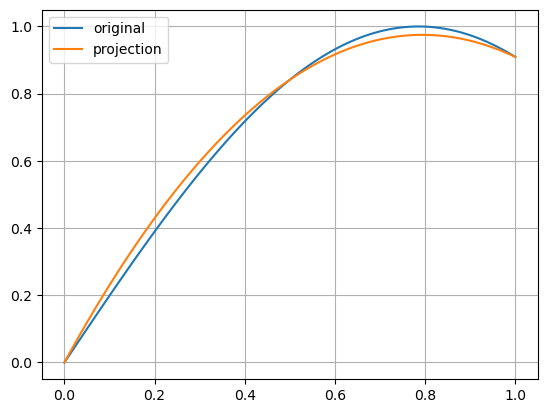

In [41]:
# points
p_list = np.array([0, 0.5, 1])

# function we want to approximate
def func(x):
    return np.sin(2*x)

# calculate the contributions of the shapefunctions
components = np.zeros(3)
shapefunctions = np.array([v_1, v_2, v_3])
for i,p in enumerate(p_list):
    components[i] = func(p)

# calculate the approximated function
def func_proj(x):
    sum = 0
    for i,c in enumerate(components):
        sum += c * shapefunctions[i](x)
    return sum

# plot original and projection
x = np.linspace(0,1,100)
plt.plot(x, func(x), label="original")
plt.plot(x, func_proj(x), label="projection")
plt.legend()
plt.grid()


print(components)


But we can still do better! When coming back to idea of cutting down our domain $\Omega$, we can find a better approximation of our solution. Moreover we are not only restricted to the interval $[0,1]$, but we can aproximate on every domain $\Omega$. For this we need to define our discretization and than map each element to our reference element $[0,1]$ to find the correct components. Then we apply these components on the shifted shapefunctions.

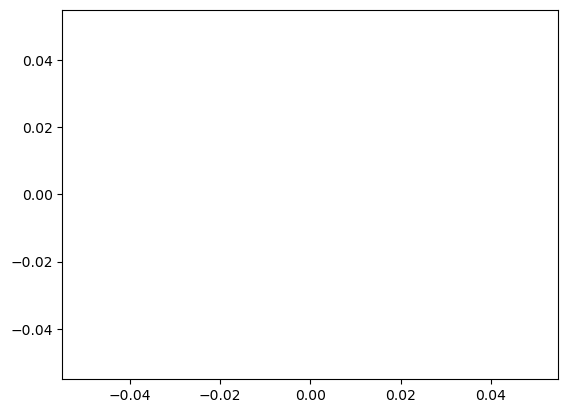

In [51]:
# define our domain + discretization
splitting = [0, 1, 1.2, 1.5, 2, 4]

nElements = len(splitting) - 1
components = np.zeros(3*nElements)
for element in range(nElements):
    a = splitting[element]
    b = splitting[element + 1]
    for i, p in enumerate(p_list):
        p_mapped = a + (b-a)*p 
        components[3*element + i] = func(p_mapped)

def func_proj(x):
    sum = x * 0
    for element in range(nElements):
        a = splitting[element]
        b = splitting[element + 1]
        x_mapped = (x - a) / (b-a)
        for i,c in enumerate(components):
            valsElement += c * shapefunctions[i](x_mapped)
        # only add in the correct domain
        sum += np.where(a<=x and x < b, valsElement, 0)
    return sum

x = plt.linspace(splitting[0], splitting[-1], 0)
plt.plot(x, func(x))